In [1]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

try:
  import hdf5storage
except:
  !pip install hdf5storage

In [2]:
import os
import numpy as np
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import hdf5storage
import gdown
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HOSVD

In [3]:
def matlen(var):
    '''Equivalent to Matlab's length()'''
    if np.size(np.shape(var))==1:
        x = np.size(var)
    else:
        x = max(np.shape(var))
    return x

def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))


def fold(B,dim,shape):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H),i,shap)
    return T

def svdtrunc(A, n):
    '''Truncated svd'''
    U, S, _ = randomized_svd(A, n_components = n)
    return U, S

In [4]:
def HOSVD_function(T,varepsilon1):
    '''Perform hosvd to tensor'''
    P = T.ndim
    U = np.zeros(shape=(1,P), dtype=object)
    UT = np.zeros(shape=(1,P), dtype=object)
    sv = np.zeros(shape=(1,P), dtype=object)
    producto = np.size(T)

    if isinstance(varepsilon1, (list, np.ndarray)):
        n = varepsilon1
    else:
        n = T.shape

    n = list(n)

    for i in range(0,P):
        n[i] = int(np.amin((n[i],producto/n[i])))
        A = unfold(T, i)

        Uaux = []
        # SVD based reduction of the current dimension (i):
        Ui, svi = svdtrunc(A, n[i])

        if n[i] < 2:
            Uaux = np.zeros((np.shape(Ui)[0],2))
            Uaux[:,0] = Ui[:,0]
            U[0][i] = Uaux
        else:
            if isinstance(varepsilon1, (list, np.ndarray)):
                pass
            else:
                count = 0
                for j in range(0,np.shape(svi)[0]):
                    if svi[j]/svi[0]<=varepsilon1:
                        pass
                    else:
                        count = count+1
                n[i] = count
            U[0][i] = Ui[:,0:n[i]]

        UT[0][i] = np.transpose(U[0][i])
        sv[0][i] = svi
    S = tprod(T, UT)
    TT = tprod(S, U)
    return TT, S, U, sv, n

In [5]:
def HOSVD(Tensor,varepsilon1,nn,n,TimePos):
    '''Perform hosvd to input data and retain all the singular values'''

    if np.iscomplex(Tensor.any()) == False:
        Tensor = Tensor.astype(np.float32)
    [TT,S2,U,sv,nn2] = HOSVD_function(Tensor,varepsilon1)

    print(f'Initial number of singular values: {n}')
    print(f'Number of singular values retained: {nn2}')

    UT = np.zeros(shape=np.shape(U), dtype=object)
    hatT = []
    for pp in range(0,np.size(nn2)):
        UT[0][pp] = np.transpose(U[0][pp])
    for kk in range(0,nn2[TimePos-1]):
        hatT.append(np.dot(sv[0][TimePos-1][kk],UT[0][TimePos-1][kk,:]))
    hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))
    return hatT,U,S2,sv,nn2,n,TT

# LOAD AND PROCESS DATA

In [6]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')

TimePos = Tensor.ndim  # Here the position of the temporal dimension is introduced

SNAP = int(Tensor.shape[-1])  # Change SNAP to reduce number of snapshots
Tensor = Tensor[..., 0:SNAP]


Retrieving folder contents


Processing file 1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz X.mat
Processing file 1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb Y.mat
Processing file 1CA9q-RAff409xVOGD2DZtsYLf95BfyGM Tensor.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz
From (redirected): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz&confirm=t&uuid=a27d04c0-578f-4a17-859c-6ffade3b738d
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/X.mat
100%|██████████| 8.23k/8.23k [00:00<00:00, 1.94MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb
From (redirected): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb&confirm=t&uuid=dd6bc01d-27dc-49f8-9465-980410cf9d5b
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/Y.mat
100%|██████████| 11.3k/11.3k [00:00<00:00, 4.33MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM
From (redirected): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsY


Loading the dataset...

Dataset loaded!


# HOSVD

In [7]:
# CALIBRATION

varepsilon1 = 1e-3  # Tolerance to truncate the number of modes retained


print('\n-----------------------------')
print('HOSVD summary:')
print('\n' + f'Number of snapshots set at: {SNAP}')
print(f'Tolerance set at {varepsilon1} for SVD')
print('\n-----------------------------')


-----------------------------
HOSVD summary:

Number of snapshots set at: 200
Tolerance set at 0.001 for SVD

-----------------------------


In [8]:
# PERFORM HOSVD
nn0 = np.array(Tensor.shape)
nn = np.array(nn0)
nn[1:np.size(nn)] = 0

print('Performing HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = HOSVD(Tensor, varepsilon1, nn, nn0, TimePos)
print('\nHOSVD complete!\n')

RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error made in the calculations: {np.round(RRMSE*100, 3)}%\n')

Performing HOSVD. Please wait...

Initial number of singular values: [  2 151 216 200]
Number of singular values retained: [2, 15, 18, 7]

HOSVD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24603/1869304093.py:17: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))
/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24603/1690191133.py:10: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))


Relative mean square error made in the calculations: 0.209%



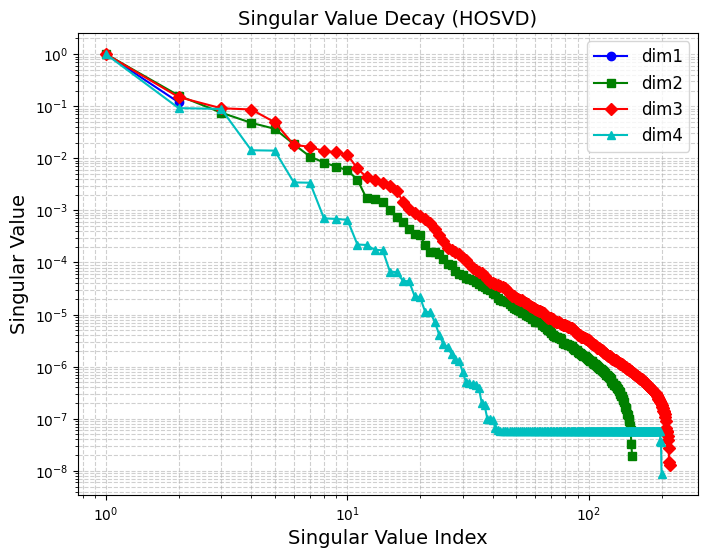

In [9]:
# Plot singular values

markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'x', '+']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

num_dims = len(sv[0,:])  # Number of dimensions

fig_sv = plt.figure(figsize=(8, 6))  # Set figure size

for i in range(num_dims):
	s = sv[0,i]
	s = s/np.max(s)
	plt.plot(
		range(1, len(s) + 1), s,  # Singular values of each dimension
		marker=markers[i % len(markers)], color=colors[i % len(colors)],
		linestyle='-', linewidth=1.5, markersize=6, label=f"dim{i+1}"
		)

plt.xlabel("Singular Value Index", fontsize=14)
plt.ylabel("Singular Value", fontsize=14)
plt.title("Singular Value Decay (HOSVD)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.xscale("log")  # Log scale for index
plt.yscale("log")  # Log scale for singular values
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["right"].set_visible(True)

plt.show()

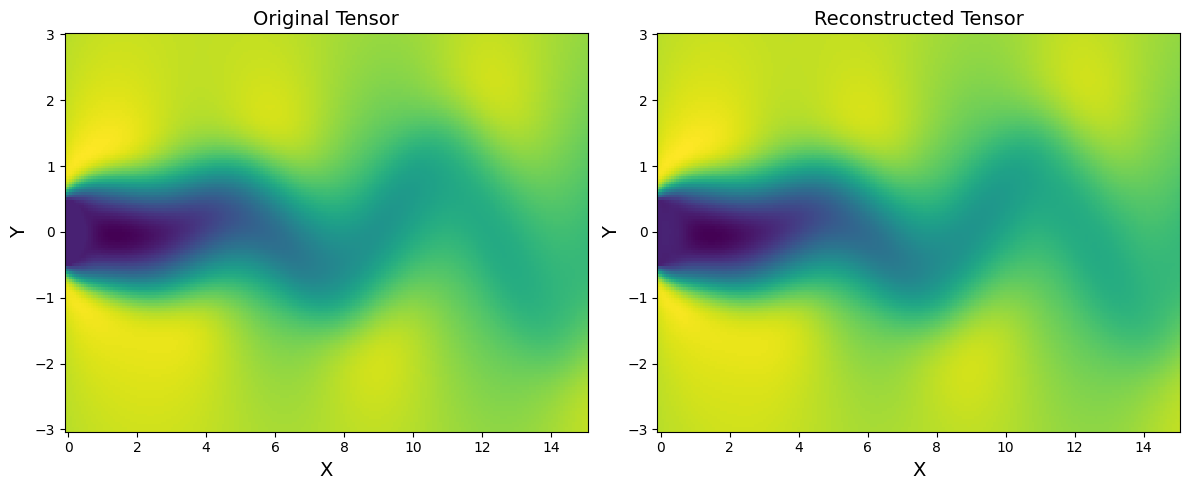

In [10]:
# Plot original vs reconstruction
f = mat73.loadmat('./Test Case/X.mat')
X = f['X']
f = mat73.loadmat('./Test Case/Y.mat')
Y = f['Y']

component = 0  # First component
original_slice = Tensor[component, :, :, SNAP-1]
reconstructed_slice = TT[component, :, :, SNAP-1]

vmin, vmax = min(original_slice.min(), reconstructed_slice.min()), max(original_slice.max(), reconstructed_slice.max())

fig_rec, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].pcolor(X,Y,original_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes[0].set_title("Original Tensor", fontsize=14)
axes[0].set_xlabel("X", fontsize=14)
axes[0].set_ylabel("Y", fontsize=14)

im2 = axes[1].pcolor(X,Y,reconstructed_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes[1].set_title("Reconstructed Tensor", fontsize=14)
axes[1].set_xlabel("X", fontsize=14)
axes[1].set_ylabel("Y", fontsize=14)

plt.tight_layout()
plt.show()